# Multi-Source Weighted-Ensemble Precipitation (MSWEP) data set

## Overview

- **Key ideas:**
    - Intensive operations that use a lot of RAM memory. Run this notebook inside `aerossol` server.
    - Multi-Source Weighted-Ensemble Precipitation (MSWEP) is a fully global historical precipitation dataset (`1979–2017` with `daily` temporal and `0.1°` spatial resolutions).
    - Explore single `global` file.
    - Explore all data available for `South America` resampled from `daily` to `annual`, `semi-monthly`, and `monthly` sums: (1), time series, (2) mean and standard deviation for all time range, (3) monthly climatology, and (4) long term ordinary least square `OLS` trends of observed data.
    - No evaluation of statistical significances for OLS trends.
    - Regrid and export precipitation data in the same spatial and temporal grid of GIMMS NDVI 3g data set. 
- **References**
    - [gloh2o: Toward Locally Relevant Global Hydrological Simulations](http://www.gloh2o.org/).

## Initial setup

In [42]:
# Load packages.
import os
import sys
import glob
import warnings
import scipy

import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import cartopy.crs as ccrs

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from dask.diagnostics import ProgressBar

warnings.filterwarnings("ignore")
xr.set_options(display_style="text")
%matplotlib inline

In [2]:
print(">>> Versions:")
print("* numpy:", np.__version__)
print("* xarray:", xr.__version__)
print("\n>>> Computer:")
!echo "* Hostname: ${HOSTNAME}"
!echo "* User: ${USER}"
!echo "* Directory: $(pwd)"
!echo "* Date: $(date)"
!echo "* CPUs: $(nproc)"

>>> Versions:
* numpy: 1.19.1
* xarray: 0.16.0

>>> Computer:
* Hostname: aerossol
* User: sandroal
* Directory: /LFASGI/sandroal/notebooks/single_variables
* Date: Wed Oct 21 14:12:41 GMT 2020
* CPUs: 24


In [3]:
%%time

# My repository.
repository = "/LFASGI/sandroal/cdlearn/"

# Include once my repository in the path for searching libraries.
if repository not in sys.path:
    sys.path.append(repository)
    
# Import my package.
import cdlearn

CPU times: user 2.32 s, sys: 340 ms, total: 2.66 s
Wall time: 8.43 s


In [4]:
# Main directory.
MAIN_FOLDER = "/LFASGI/sandroal/data_sets/MSWEP/GLOBAL_DAILY_010DEG/"

# Map borders for South America.
loni, lonf, lati, latf = -90, -30, -60, 20

# Final results.
save_fig = True

# Data files location.
FIG_FOLDER = "/LFASGI/sandroal/images/single_variables/"

In [5]:
# One file for each year (2001 - 2018). 
FILES_PATHS = sorted(glob.glob(MAIN_FOLDER + "*nc"))

# Show some data files paths.
FILES_PATHS[:5]

['/LFASGI/sandroal/data_sets/MSWEP/GLOBAL_DAILY_010DEG/197901.nc',
 '/LFASGI/sandroal/data_sets/MSWEP/GLOBAL_DAILY_010DEG/197902.nc',
 '/LFASGI/sandroal/data_sets/MSWEP/GLOBAL_DAILY_010DEG/197903.nc',
 '/LFASGI/sandroal/data_sets/MSWEP/GLOBAL_DAILY_010DEG/197904.nc',
 '/LFASGI/sandroal/data_sets/MSWEP/GLOBAL_DAILY_010DEG/197905.nc']

## Explore single global file

In [6]:
%%time

# Random choice of a file.
RFP = np.random.choice(FILES_PATHS)
DS = xr.open_dataset(RFP)

# Show it.
print(DS)

<xarray.Dataset>
Dimensions:        (lat: 1800, lon: 3600, time: 30)
Coordinates:
  * time           (time) datetime64[ns] 2015-09-01 2015-09-02 ... 2015-09-30
  * lon            (lon) float64 -179.9 -179.8 -179.8 ... 179.8 179.8 179.9
  * lat            (lat) float64 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
Data variables:
    precipitation  (time, lat, lon) float32 ...
CPU times: user 24 ms, sys: 4 ms, total: 28 ms
Wall time: 126 ms


In [7]:
print(">>> Units:", DS.precipitation.units)
nnans = np.sum(np.isnan(DS.precipitation.values.flatten()))
size = DS.precipitation.size
print(">>> Total nans:", nnans, "(%.2f %%)" %(nnans / size * 100))

>>> Units: mm/d
>>> Total nans: 278040 (0.14 %)


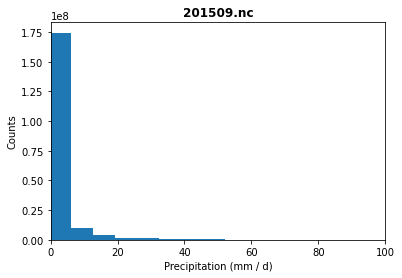

In [8]:
plt.hist(DS.precipitation.values.flatten(), bins=100);
plt.ylabel("Counts"); plt.xlabel("Precipitation (mm / d)")
plt.title(os.path.basename(RFP), weight="bold");
plt.xlim((0, 100));

CPU times: user 4.28 s, sys: 912 ms, total: 5.19 s
Wall time: 6.15 s


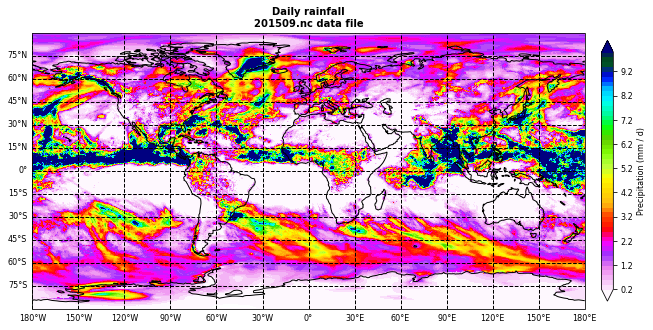

In [9]:
%%time

# Set figure size, projection, and extent.
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90]) 

# Add coastlines and formatted gridlines.
ax.coastlines(resolution="110m", linewidth=1)
gl = ax.gridlines(
    crs=ccrs.PlateCarree(), 
    draw_labels=True, 
    linewidth=1, 
    color="black", 
    linestyle="--"
)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180 + 30, 30))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90 + 15, 15))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {"size": 8, "color": "black"}
gl.ylabel_style = {"size": 8, "color": "black"}

# Draw the plot.
p = DS.precipitation.mean("time").plot(
    ax=ax,
    vmin=0.2,
    vmax=10,
    levels=np.arange(0.2, 10 + 0.2, 0.2),
    cmap=plt.cm.gist_ncar_r,
    add_colorbar=False,
    add_labels=False
)

# Adjustments.
plt.title(f"Daily rainfall\n" + os.path.basename(RFP) + " data file", weight="bold", size=10)
cb = plt.colorbar(
    mappable=p, 
    ax=ax, 
    orientation="vertical", 
    pad=0.025, 
    shrink=0.8,
    extend="both"
)
cb.set_label("Precipitation (mm / d)", size=8)
cb.ax.tick_params(labelsize=8) 

## Daily data

In [10]:
%%time

# Lazy read.
DS_DAY = xr.open_mfdataset(
    paths=FILES_PATHS,
    concat_dim="time",
    chunks={} 
)

# My ninja way.
DS_DAY = cdlearn.utils.organize_data(DS_DAY)

# South America .
DS_DAY = DS_DAY.sel(lat=slice(lati, latf), lon=slice(loni, lonf))

# Show it.
print(DS_DAY)

<xarray.Dataset>
Dimensions:        (lat: 800, lon: 600, time: 14184)
Coordinates:
  * lat            (lat) float64 -59.95 -59.85 -59.75 ... 19.75 19.85 19.95
  * lon            (lon) float64 -89.95 -89.85 -89.75 ... -30.25 -30.15 -30.05
  * time           (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2017-10-31
Data variables:
    precipitation  (time, lat, lon) float32 dask.array<chunksize=(31, 800, 600), meta=np.ndarray>
CPU times: user 6.96 s, sys: 436 ms, total: 7.39 s
Wall time: 31.3 s


In [11]:
print(">>> Size in GB (if loaded! do not load it! too much RAM!):", DS_DAY.nbytes / 1e9)

>>> Size in GB (if loaded! do not load it! too much RAM!): 27.233404672


## Obtain annual cumulative precipitation

In [12]:
%%time

# Monthly resample.
DS_ANU = DS_DAY.resample({"time": "YS"}).sum("time")

# Show it.
print(DS_ANU)

<xarray.Dataset>
Dimensions:        (lat: 800, lon: 600, time: 39)
Coordinates:
  * time           (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2017-01-01
  * lat            (lat) float64 -59.95 -59.85 -59.75 ... 19.75 19.85 19.95
  * lon            (lon) float64 -89.95 -89.85 -89.75 ... -30.25 -30.15 -30.05
Data variables:
    precipitation  (time, lat, lon) float32 dask.array<chunksize=(1, 800, 600), meta=np.ndarray>
CPU times: user 400 ms, sys: 0 ns, total: 400 ms
Wall time: 498 ms


In [13]:
print(">>> Size in GB (resampled):", DS_ANU.nbytes / 1e9)

>>> Size in GB (resampled): 0.074891512


In [14]:
# Load into memory.
with ProgressBar():
    DS_ANU = DS_ANU.load()

[########################################] | 100% Completed | 51min  9.4s


## Obtain monthly cumulative precipitation

In [15]:
%%time

# Monthly resample.
DS_MON = DS_DAY.resample({"time": "MS"}).sum("time")

# Show it.
print(DS_MON)

<xarray.Dataset>
Dimensions:        (lat: 800, lon: 600, time: 466)
Coordinates:
  * time           (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2017-10-01
  * lat            (lat) float64 -59.95 -59.85 -59.75 ... 19.75 19.85 19.95
  * lon            (lon) float64 -89.95 -89.85 -89.75 ... -30.25 -30.15 -30.05
Data variables:
    precipitation  (time, lat, lon) float32 dask.array<chunksize=(1, 800, 600), meta=np.ndarray>
CPU times: user 4.24 s, sys: 36 ms, total: 4.28 s
Wall time: 4.74 s


In [16]:
print(">>> Size in GB (resampled):", DS_MON.nbytes / 1e9)

>>> Size in GB (resampled): 0.894734928


In [17]:
# Load into memory.
with ProgressBar():
    DS_MON = DS_MON.load()

[########################################] | 100% Completed | 53min 36.4s


## Obtain semi-monthly cumulative precipitation

In [18]:
%%time

# Monthly resample.
DS_SMO = DS_DAY.resample({"time": "SMS"}).sum("time")

# Show it.
print(DS_SMO)

<xarray.Dataset>
Dimensions:        (lat: 800, lon: 600, time: 932)
Coordinates:
  * time           (time) datetime64[ns] 1979-01-01 1979-01-15 ... 2017-10-15
  * lat            (lat) float64 -59.95 -59.85 -59.75 ... 19.75 19.85 19.95
  * lon            (lon) float64 -89.95 -89.85 -89.75 ... -30.25 -30.15 -30.05
Data variables:
    precipitation  (time, lat, lon) float32 dask.array<chunksize=(1, 800, 600), meta=np.ndarray>
CPU times: user 8.44 s, sys: 244 ms, total: 8.69 s
Wall time: 8.72 s


In [19]:
print(">>> Size in GB (resampled):", DS_SMO.nbytes / 1e9)

>>> Size in GB (resampled): 1.789458656


In [20]:
# Load into memory.
with ProgressBar():
    DS_SMO = DS_SMO.load()

[########################################] | 100% Completed | 53min 44.2s


## Time series in a random grid point

In [21]:
%%time

# Random selection of a land grid point (True).
play = True

def pick_one_grid_point():
    loc_lat = np.random.choice(DS_DAY.lat)
    loc_lon = np.random.choice(DS_DAY.lon)
    selection = {"lat": loc_lat, "lon": loc_lon}
    return selection
    
if play:

    selection = pick_one_grid_point()
    suptitle = "Base point for nearest one (lat=%.2f, lon=%.2f)" %(selection["lat"], selection["lon"])
    
else:
    # Select a grid point.
    loc_lat, loc_lon, method = -21.0, -45.0, "nearest"
    selection = {"lat": loc_lat, "lon": loc_lon, "method": method}
    suptitle = "Minas Gerais State, Brazil (lat=%.2f, lon=%.2f)" %(selection["lat"], selection["lon"])

# Show it.
print(">>> Selection:\n", selection)

>>> Selection:
 {'lat': -55.550000000000004, 'lon': -45.94999999999999}
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.12 ms


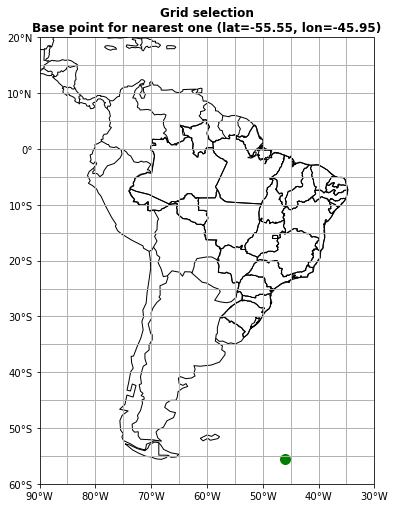

In [22]:
# Map.
axgr = cdlearn.maps.south_america(
    figsize=(6, 12), 
    nrows_ncols=(1, 1),
    titles=["Grid selection\n" + suptitle],
    cbar_mode=None
)

_ = axgr[0].scatter(
    x=selection["lon"], 
    y=selection["lat"], 
    s=100,
    marker="o", 
    color="green",
)

CPU times: user 3.1 s, sys: 296 ms, total: 3.4 s
Wall time: 15.6 s


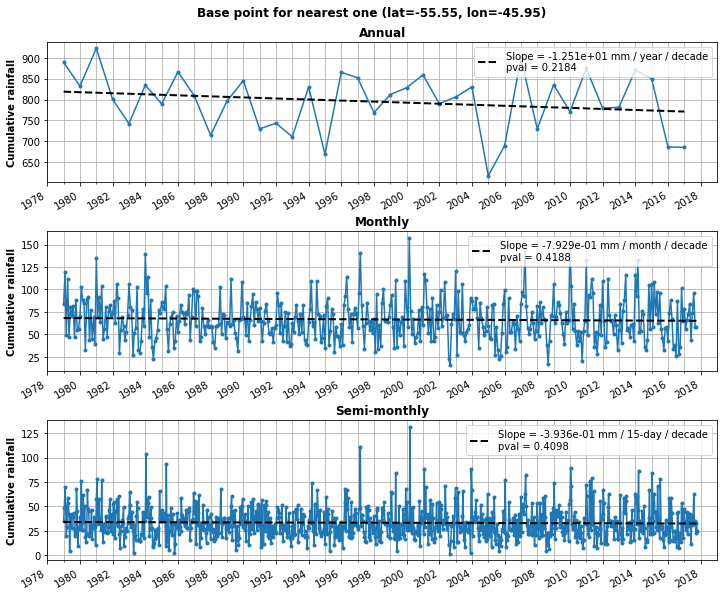

In [23]:
%%time

# Make figure.
fig, axes = plt.subplots(3, 1, figsize=(12, 9))
axes = axes.flatten()

# Time series.
DS_ANU.precipitation.sel(**selection).plot(ax=axes[0], marker=".")
DS_MON.precipitation.sel(**selection).plot(ax=axes[1], marker=".")
DS_SMO.precipitation.sel(**selection).plot(ax=axes[2], marker=".")

# Annual linear OLS regression.
Y = DS_ANU.precipitation.sel(**selection).values
X = np.arange(Y.shape[0])
slope, intercept, _, p_value, _ = scipy.stats.linregress(X, Y)
axes[0].plot(DS_ANU.time, slope * X + intercept, ls="--", lw=2, color="black",
    label="Slope = %.3e mm / year / decade" %(10 * slope)+ \
          "\npval = %.4f" %(p_value))
    
# Monthly linear OLS regression.
Y = DS_MON.precipitation.sel(**selection).values
X = np.arange(Y.shape[0])
slope, intercept, _, p_value, _ = scipy.stats.linregress(X, Y)
axes[1].plot(DS_MON.time, slope * X + intercept, ls="--", lw=2, color="black",
    label="Slope = %.3e mm / month / decade" %(120 * slope)+ \
          "\npval = %.4f" %(p_value))    
    
# Semi-monthly linear OLS regression.
Y = DS_SMO.precipitation.sel(**selection).values
X = np.arange(Y.shape[0])
slope, intercept, _, p_value, _ = scipy.stats.linregress(X, Y)
axes[2].plot(DS_SMO.time, slope * X + intercept, ls="--", lw=2, color="black",
    label="Slope = %.3e mm / 15-day / decade" %(240 * slope)+ \
          "\npval = %.4f" %(p_value))     

# Adjustments.
for axis in axes:
    axis.legend(loc=1)
    yi = np.unique(DS_ANU.time.dt.year)[0] - 1
    yf = np.unique(DS_ANU.time.dt.year)[-1]
    axis.grid(which="both")
    axis.xaxis.set_major_locator(mdates.YearLocator(2))
    axis.xaxis.set_minor_locator(mdates.YearLocator(1))
    axis.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    axis.set_xlim(pd.Timestamp(str(yi)), pd.Timestamp(str(yf + 2)))
    axis.set_xticks(pd.date_range(start=str(yi), end=str(yf), freq="1YS"), minor=True)
    axis.set_xlabel(None)
    axis.set_ylabel("Cumulative rainfall", weight="bold")
    
# More adjustments.
axes[0].set_title("Annual", weight="bold")
axes[1].set_title("Monthly", weight="bold")
axes[2].set_title("Semi-monthly", weight="bold")
fig.suptitle(suptitle, weight="bold")
plt.subplots_adjust(top=0.925, hspace=0.35)

# Save figure.
if save_fig:
    plt.savefig(
        FIG_FOLDER + "precipitation_mswep_grid_time_series.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

## Means and standard deviations

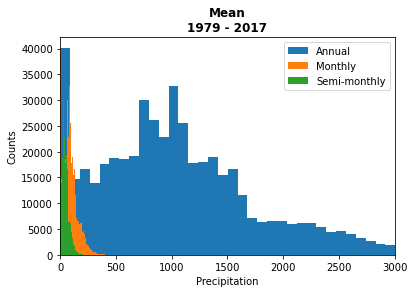

In [24]:
plt.hist(DS_ANU.precipitation.mean("time").values.flatten(), bins=100, label="Annual")
plt.hist(DS_MON.precipitation.mean("time").values.flatten(), bins=100, label="Monthly")
plt.hist(DS_SMO.precipitation.mean("time").values.flatten(), bins=100, label="Semi-monthly")
plt.xlim((0, 3000))
plt.legend()
plt.ylabel("Counts"); plt.xlabel("Precipitation")
_ = plt.title("Mean\n1979 - 2017", weight="bold")

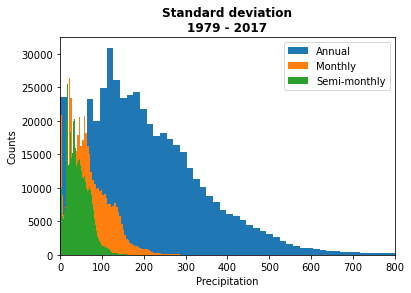

In [25]:
plt.hist(DS_ANU.precipitation.std("time").values.flatten(), bins=100, label="Annual")
plt.hist(DS_MON.precipitation.std("time").values.flatten(), bins=100, label="Monthly")
plt.hist(DS_SMO.precipitation.std("time").values.flatten(), bins=100, label="Semi-monthly")
plt.xlim((0, 800))
plt.legend()
plt.ylabel("Counts"); plt.xlabel("Precipitation")
_ = plt.title("Standard deviation\n1979 - 2017", weight="bold")

CPU times: user 6.04 s, sys: 160 ms, total: 6.2 s
Wall time: 9.93 s


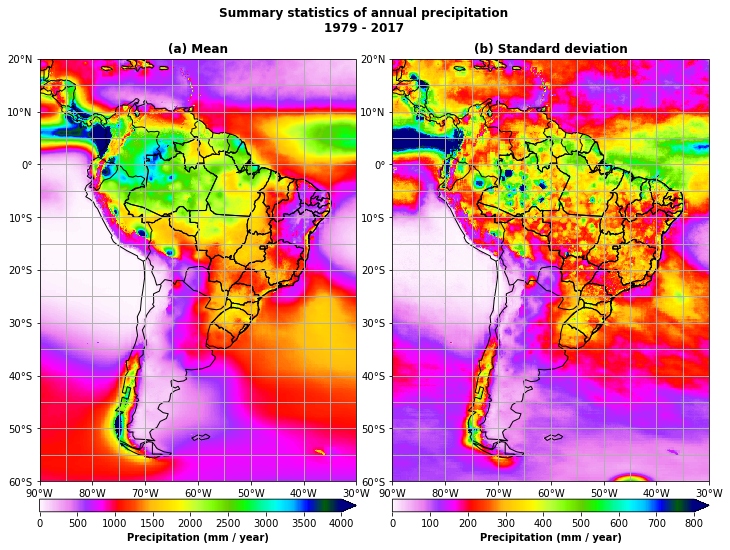

In [26]:
%%time

# Maps.
axgr = cdlearn.maps.south_america(
    figsize=(12, 13), 
    nrows_ncols=(1, 2),
    axes_pad=0.50,
    suptitle="Summary statistics of annual precipitation\n1979 - 2017",    
    suptitle_y=0.80,
    titles=["(a) Mean", "(b) Standard deviation"],
    cbar_mode="each",
    cbar_location="bottom"
)

# Plot mean results.
plotmap = DS_ANU.precipitation.mean("time").plot(
    ax=axgr[0],
    vmin=0,
    vmax=4000,
    cmap=plt.cm.gist_ncar_r,
    add_colorbar=False,
    add_labels=False
)  

# Color bar.
cb = plt.colorbar(
    plotmap, 
    cax=axgr.cbar_axes[0], 
    orientation="horizontal", 
    extend="max",
    pad=0.50
)    
cb.set_label("Precipitation (mm / year)", weight="bold")

# Plot deviation results.
plotmap = DS_ANU.precipitation.std("time").plot(
    ax=axgr[1],
    vmin=0,
    vmax=800,
    cmap=plt.cm.gist_ncar_r,
    add_colorbar=False,
    add_labels=False
)    

# Color bar.
cb = plt.colorbar(
    plotmap, 
    cax=axgr.cbar_axes[1], 
    orientation="horizontal", 
    extend="max"  
)    
cb.set_label("Precipitation (mm / year)", weight="bold")

# Save figure.
if save_fig:
    plt.savefig(
        FIG_FOLDER + "precipitation_mswep_annual_mean_and_standard_deviation.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

CPU times: user 9.24 s, sys: 920 ms, total: 10.2 s
Wall time: 19.1 s


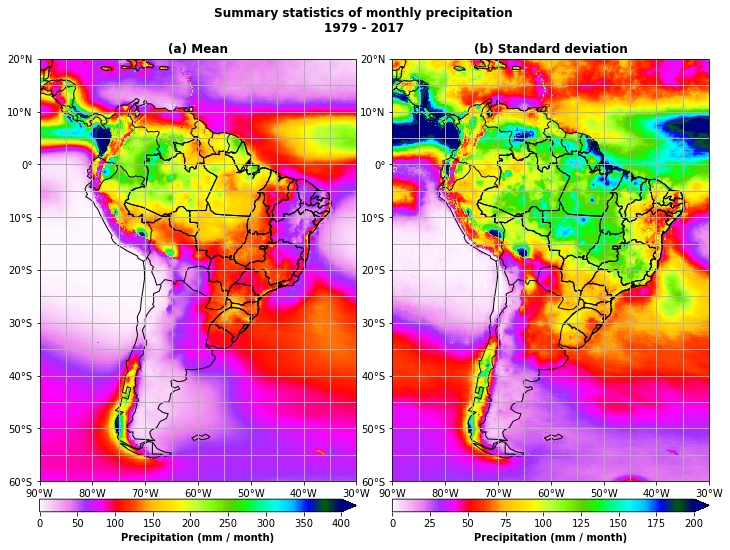

In [27]:
%%time

# Maps.
axgr = cdlearn.maps.south_america(
    figsize=(12, 13), 
    nrows_ncols=(1, 2),
    axes_pad=0.50,
    suptitle="Summary statistics of monthly precipitation\n1979 - 2017",    
    suptitle_y=0.80,
    titles=["(a) Mean", "(b) Standard deviation"],
    cbar_mode="each",
    cbar_location="bottom"
)

# Plot mean results.
plotmap = DS_MON.precipitation.mean("time").plot(
    ax=axgr[0],
    vmin=0,
    vmax=400,
    cmap=plt.cm.gist_ncar_r,
    add_colorbar=False,
    add_labels=False
)  

# Color bar.
cb = plt.colorbar(
    plotmap, 
    cax=axgr.cbar_axes[0], 
    orientation="horizontal", 
    extend="max",
    pad=0.50
)    
cb.set_label("Precipitation (mm / month)", weight="bold")

# Plot deviation results.
plotmap = DS_MON.precipitation.std("time").plot(
    ax=axgr[1],
    vmin=0,
    vmax=200,
    cmap=plt.cm.gist_ncar_r,
    add_colorbar=False,
    add_labels=False
)    

# Color bar.
cb = plt.colorbar(
    plotmap, 
    cax=axgr.cbar_axes[1], 
    orientation="horizontal", 
    extend="max"  
)    
cb.set_label("Precipitation (mm / month)", weight="bold")

# Save figure.
if save_fig:
    plt.savefig(
        FIG_FOLDER + "precipitation_mswep_monthly_mean_and_standard_deviation.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

CPU times: user 19.5 s, sys: 2.03 s, total: 21.5 s
Wall time: 26.8 s


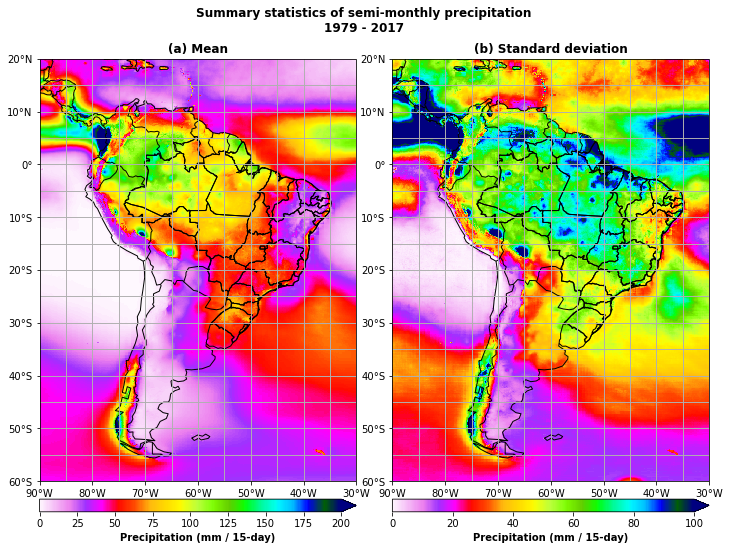

In [28]:
%%time

# Maps.
axgr = cdlearn.maps.south_america(
    figsize=(12, 13), 
    nrows_ncols=(1, 2),
    axes_pad=0.50,
    suptitle="Summary statistics of semi-monthly precipitation\n1979 - 2017",    
    suptitle_y=0.80,
    titles=["(a) Mean", "(b) Standard deviation"],
    cbar_mode="each",
    cbar_location="bottom"
)

# Plot mean results.
plotmap = DS_SMO.precipitation.mean("time").plot(
    ax=axgr[0],
    vmin=0,
    vmax=200,
    cmap=plt.cm.gist_ncar_r,
    add_colorbar=False,
    add_labels=False
)  

# Color bar.
cb = plt.colorbar(
    plotmap, 
    cax=axgr.cbar_axes[0], 
    orientation="horizontal", 
    extend="max",
    pad=0.50
)    
cb.set_label("Precipitation (mm / 15-day)", weight="bold")

# Plot deviation results.
plotmap = DS_SMO.precipitation.std("time").plot(
    ax=axgr[1],
    vmin=0,
    vmax=100,
    cmap=plt.cm.gist_ncar_r,
    add_colorbar=False,
    add_labels=False
)    

# Color bar.
cb = plt.colorbar(
    plotmap, 
    cax=axgr.cbar_axes[1], 
    orientation="horizontal", 
    extend="max"  
)    
cb.set_label("Precipitation (mm / 15-day)", weight="bold")

# Save figure.
if save_fig:
    plt.savefig(
        FIG_FOLDER + "precipitation_mswep_15day_mean_and_standard_deviation.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

## Monthly climatology

In [29]:
%%time

# Monthly means.
DA_mm = DS_MON.precipitation.groupby("time.month").mean("time")

CPU times: user 1.38 s, sys: 1.14 s, total: 2.52 s
Wall time: 2.54 s


CPU times: user 29.5 s, sys: 364 ms, total: 29.8 s
Wall time: 38.3 s


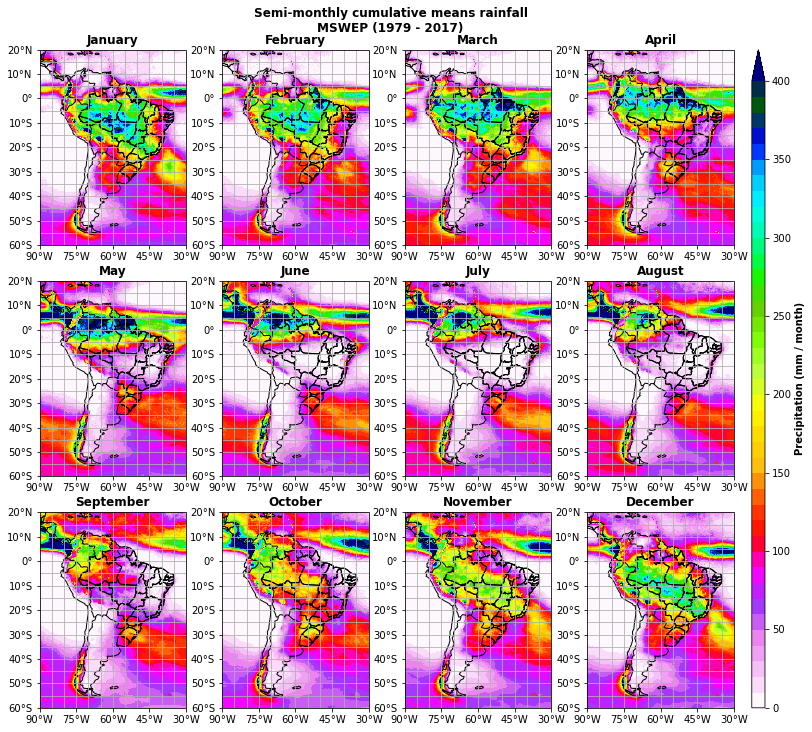

In [30]:
%%time

# Grid of maps.
axgr = cdlearn.maps.south_america_months(
    title="Monthly cumulative means rainfall\nMSWEP (1979 - 2017)"
)

# Plot data on these maps.
for index, axis in enumerate(axgr):

    # Data limits.
    vmin = 0; vmax = 400; dv = 20
    
    plotmap = DA_mm.isel(month=index).plot(
        ax=axis,
        vmin=vmin,
        vmax=vmax,
        levels=np.arange(vmin, vmax + dv/2, dv/2),
        cmap=plt.cm.gist_ncar_r,
        add_colorbar=False,
        add_labels=False
    )
    
# Fill common colorbar.   
cb = plt.colorbar(plotmap, cax=axgr.cbar_axes[0], orientation="vertical")    
cb.set_label("Precipitation (mm / month)", weight="bold")

# Save figures.
if save_fig:
    plt.savefig(
        FIG_FOLDER + "precipitation_mswep_monthly_climatology.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )    

## Long term trends

In [31]:
# Slope, intercept, r value, p value, and standard error for linear regression. Annual trends.
DS_TRENDS_ANU = cdlearn.statistics.linear_regression(
    data_set=DS_ANU,
    var_code="precipitation", 
    verbose=True
)

>>> Loop over grid points ...


 99% (479976 of 480000) |############### | Elapsed Time: 0:05:58 ETA:   0:00:00

In [32]:
# Slope, intercept, r value, p value, and standard error for linear regression. Monthly trends.
DS_TRENDS_MON = cdlearn.statistics.linear_regression(
    data_set=DS_MON,
    var_code="precipitation", 
    verbose=True
)

>>> Loop over grid points ...


 99% (479920 of 480000) |############### | Elapsed Time: 0:06:35 ETA:   0:00:00

In [33]:
# Slope, intercept, r value, p value, and standard error for linear regression. Semi-monthly trends.
DS_TRENDS_SMO = cdlearn.statistics.linear_regression(
    data_set=DS_SMO,
    var_code="precipitation", 
    verbose=True
)

>>> Loop over grid points ...


 99% (479922 of 480000) |############### | Elapsed Time: 0:06:52 ETA:   0:00:00

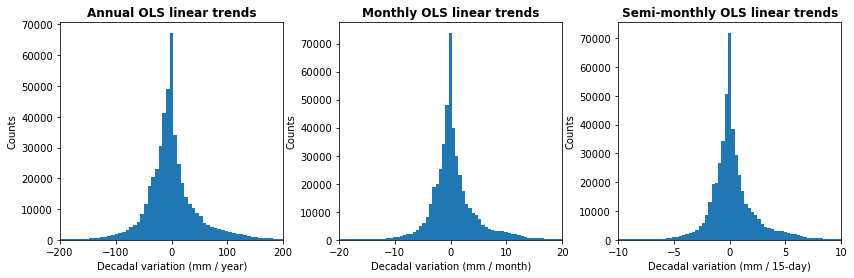

In [34]:
# Decadal variation.
fac_anu = 10
fac_mon = 120
fac_smo = 240

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
axes.flatten()
axes[0].hist(fac_anu * DS_TRENDS_ANU.slopes.values.flatten(), bins=200)
axes[1].hist(fac_mon * DS_TRENDS_MON.slopes.values.flatten(), bins=200)
axes[2].hist(fac_smo * DS_TRENDS_SMO.slopes.values.flatten(), bins=200)
axes[0].set_xlim((-200, 200)); axes[1].set_xlim((-20, 20)); axes[2].set_xlim((-10, 10))
axes[0].set_xlabel("Decadal variation (mm / year)"); axes[0].set_ylabel("Counts")
axes[1].set_xlabel("Decadal variation (mm / month)"); axes[1].set_ylabel("Counts")
axes[2].set_xlabel("Decadal variation (mm / 15-day)"); axes[2].set_ylabel("Counts")
axes[0].set_title("Annual OLS linear trends", weight="bold")
axes[1].set_title("Monthly OLS linear trends", weight="bold")
_ = axes[2].set_title("Semi-monthly OLS linear trends", weight="bold")
plt.subplots_adjust(wspace=0.25)

CPU times: user 3.96 s, sys: 24 ms, total: 3.98 s
Wall time: 4.9 s


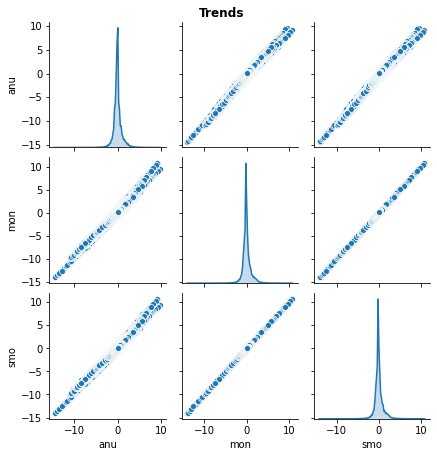

In [35]:
%%time

# Data.
data = np.vstack((
        fac_anu * DS_TRENDS_ANU.slopes.values.flatten(),
        fac_mon * DS_TRENDS_MON.slopes.values.flatten(),
        fac_smo * DS_TRENDS_SMO.slopes.values.flatten()
)).T

# Scale.
data = (data - data.mean(axis=0, keepdims=True)) / data.std(axis=0, keepdims=True)

# For pair plots.
df_trends = pd.DataFrame(data=data, columns=["anu", "mon", "smo"])

# Pair plots.
g = sns.pairplot(df_trends, diag_kind="kde", height=2.0)
_ = g.fig.suptitle("Trends", y=1.025, weight="bold")

CPU times: user 8.3 s, sys: 72 ms, total: 8.37 s
Wall time: 19.9 s


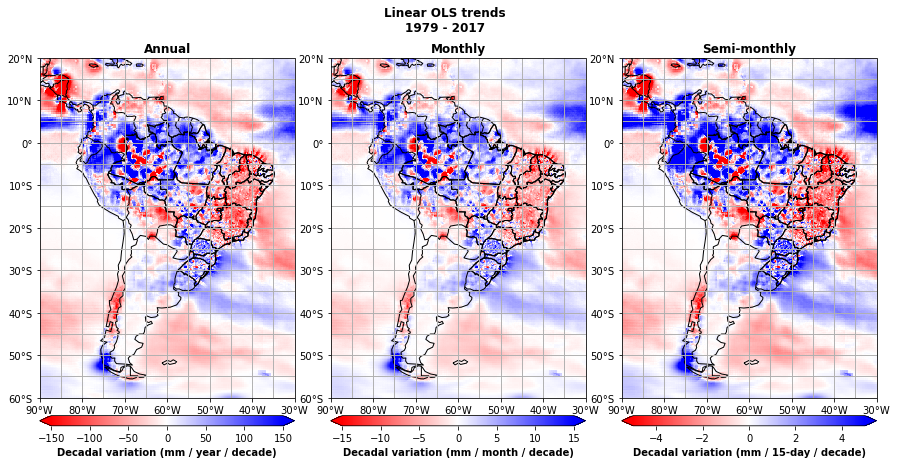

In [36]:
%%time

# Maps.
axgr = cdlearn.maps.south_america(
    figsize=(15, 12), 
    nrows_ncols=(1, 3),
    axes_pad=0.50,
    suptitle="Linear OLS trends\n1979 - 2017",    
    suptitle_y=0.775,
    titles=["Annual", "Monthly", "Semi-monthly"],
    cbar_mode="each",
    cbar_location="bottom"
)

# Plot annual slopes.
plotmap = (fac_anu * DS_TRENDS_ANU.slopes).plot(
    ax=axgr[0],
    vmin=-150,
    vmax=150,
    cmap=plt.cm.bwr_r,
    add_colorbar=False,
    add_labels=False
)  

# Color bar.
cb = plt.colorbar(
    plotmap, 
    cax=axgr.cbar_axes[0], 
    orientation="horizontal", 
    extend="both",
    pad=0.50
)    
cb.set_label("Decadal variation (mm / year / decade)", weight="bold")

# Plot monthly slopes.
plotmap = (fac_mon * DS_TRENDS_MON.slopes).plot(
    ax=axgr[1],
    vmin=-15,
    vmax=15,
    cmap=plt.cm.bwr_r,
    add_colorbar=False,
    add_labels=False
)  

# Color bar.
cb = plt.colorbar(
    plotmap, 
    cax=axgr.cbar_axes[1], 
    orientation="horizontal", 
    extend="both",
    pad=0.50
)    
cb.set_label("Decadal variation (mm / month / decade)", weight="bold")

# Plot semi-monthly slopes.
plotmap = (fac_smo * DS_TRENDS_SMO.slopes).plot(
    ax=axgr[2],
    vmin=-5,
    vmax=5,
    cmap=plt.cm.bwr_r,
    add_colorbar=False,
    add_labels=False
)  

# Color bar.
cb = plt.colorbar(
    plotmap, 
    cax=axgr.cbar_axes[2], 
    orientation="horizontal", 
    extend="both",
    pad=0.50
)    
cb.set_label("Decadal variation (mm / 15-day / decade)", weight="bold")

# Save figures.
if save_fig:
    plt.savefig(
        FIG_FOLDER + "precipitation_mswep_trends.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )    

## Regrid and export data

In [37]:
%%time 

# Load NDVI data into memory.
DS_NDVI = xr.open_dataset(
    filename_or_obj="/LFASGI/sandroal/data_sets/GIMMS/ppdata_ndvi.nc"
).load()

# Show it.
print(DS_NDVI)

<xarray.Dataset>
Dimensions:    (lat: 960, lon: 720, time: 828)
Coordinates:
    land_mask  (lat, lon) bool False False False False ... False False False
  * lon        (lon) float64 -89.96 -89.88 -89.79 ... -30.21 -30.13 -30.04
  * lat        (lat) float64 -59.96 -59.88 -59.79 -59.71 ... 19.79 19.88 19.96
  * time       (time) datetime64[ns] 1981-07-01 1981-07-15 ... 2015-12-15
Data variables:
    ndvi       (time, lat, lon) float32 -0.3 -0.3 -0.3 -0.3 ... -0.3 -0.3 -0.3
Attributes:
    FileName:              ndvi3g_geo_v1_1981_0712.nc4
    Institution:           NASA/GSFC GIMMS
    Data:                  NDVI3g version 1
    Reference:             1. Pinzon, J.E.; Tucker, C.J.                     ...
    CommentsVersion1:      version1 includes two major fixes (a and b), and t...
    Temporalrange:         1981-07-01 -> 2015-12-31
    Year:                  1981.0
    RangeSemester:         Jul 1 - Dec 31 (7:0.5:12.5)
    SpatialResolution:     1/12 x 1/12 degrees
    TemporalResolut

In [38]:
# In accordance with GIMMS NDVI 3g original spatial grid.
NEW_GRID = xr.Dataset(
    coords={"lat": (["lat"], DS_NDVI.lat.values), 
            "lon": (["lon"], DS_NDVI.lon.values)}
)

# Show it.
print(NEW_GRID)

<xarray.Dataset>
Dimensions:  (lat: 960, lon: 720)
Coordinates:
  * lat      (lat) float64 -59.96 -59.88 -59.79 -59.71 ... 19.79 19.88 19.96
  * lon      (lon) float64 -89.96 -89.88 -89.79 -89.71 ... -30.21 -30.13 -30.04
Data variables:
    *empty*


In [49]:
%%time

# Regridder object.
REGRIDDER = xe.Regridder(
    ds_in=DS_SMO,
    ds_out=NEW_GRID,
    method="bilinear",
    periodic=False, # Not global data!
    filename="mswep_to_gimms_regriddrer.nc",
    reuse_weights=True
)

Create weight file: mswep_to_gimms_regriddrer.nc
CPU times: user 41.8 s, sys: 1.85 s, total: 43.6 s
Wall time: 50.8 s


In [50]:
%%time

# Regrid data.
DS_SMO_REG = REGRIDDER(DS_SMO)

# Show it.
print(DS_SMO_REG)

using dimensions ('lat', 'lon') from data variable precipitation as the horizontal dimensions for this dataset.
<xarray.Dataset>
Dimensions:        (lat: 960, lon: 720, time: 932)
Coordinates:
  * time           (time) datetime64[ns] 1979-01-01 1979-01-15 ... 2017-10-15
  * lon            (lon) float64 -89.96 -89.88 -89.79 ... -30.21 -30.13 -30.04
  * lat            (lat) float64 -59.96 -59.88 -59.79 ... 19.79 19.88 19.96
Data variables:
    precipitation  (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    regrid_method:  bilinear
CPU times: user 8.18 s, sys: 3.49 s, total: 11.7 s
Wall time: 11.8 s


In [57]:
%%time

# Export data.
DS_SMO_REG, _ = xr.align(DS_SMO_REG, DS_NDVI)
DS_SMO_REG = DS_SMO_REG.assign_coords({"land_mask": DS_NDVI.land_mask})
ppdata_fp = "/LFASGI/sandroal/data_sets/MSWEP/ppdata_precipitation.nc"
DS_SMO_REG.to_netcdf(path=ppdata_fp, mode="w")

CPU times: user 3.06 s, sys: 9.09 s, total: 12.2 s
Wall time: 53.6 s
